# Diseño de una Montaña Rusa



<em>
Una empresa de parques de atracciones está diseñando una nueva montaña
rusa y necesita que la trayectoria de la vía sea suave y continúe en todo el recorrido.
Para esto, solicitan que se realice un modelo matemático que utilice un método de
trazador cúbico sujeto. Además, requieren que el análisis de la estabilidad
estructural de la vía se haga utilizando un polinomio de mínimos cuadrados para
ajustar los datos experimentales obtenidos de las pruebas de tensión y compresión
del material. El diseño también debe incluir el uso de polinomios ortogonales para
optimizar la forma de ciertos tramos de la vía y mejorar la experiencia del usuario.
Finalmente, se necesita resolver un sistema de ecuaciones para determinar las
fuerzas que actúan en los puntos críticos de la estructura.
    </em>

<hr>

<h4>Integrantes</h4>
    <ul>
        <li><b>Eduardo Tovar CI: 28138831</b></li>
        <li><b>Luis Leon CI:31139586</b></li>
        <li><b>Juan D. Cordero CI:31115188</b></li>
        <li><b>Nelson Guerrero CI: 32067861</b></li>
        <li><b>Alejandro Lopez CI: 30914440</b></li>
    </ul>

<hr>

## Tomando los datos de los CSV 

In [34]:
 import pandas as pd
import numpy as np
import sympy as sp

class DataProcessor:
    def __init__(self, file1, file2, file3):
        self.datos_1 = pd.read_csv(file1)
        self.datos_2 = pd.read_csv(file2)
        self.datos_3 = pd.read_csv(file3, header=None)
        self.matriz_1 = None
        self.matriz_2 = None
        self.matriz_3 = None
        self.xi_1 = None
        self.yi_1 = None
        self.xi_2 = None
        self.yi_2 = None
        self.A = None
        self.b = None

    def listador(self, data):
        matriz = []
        for _, fila in data.iterrows():
            fila_vector = fila.tolist()
            matriz.append(fila_vector)
        return matriz

    def procesar_datos(self):
        # Procesar matriz_1
        self.matriz_1 = self.listador(self.datos_1)
        self.xi_1 = self.matriz_1[0]
        self.yi_1 = self.matriz_1[1]

        # Procesar matriz_2
        self.matriz_2 = self.listador(self.datos_2)
        self.xi_2 = np.array(self.matriz_2[0])
        self.yi_2 = np.array(self.matriz_2[1])

        # Procesar matriz_3
        self.matriz_3 = self.listador(self.datos_3)
        self.b = self.datos_3.iloc[3, :].values.reshape(-1, 1)  # Vector columna
        self.A = sp.Matrix(self.matriz_3[:-1])
        self.b = sp.Matrix(self.b)

    def mostrar_datos(self):
        print("Datos obtenidos de forma correcta:")
        print("xi_1:", self.xi_1)
        print("yi_1:", self.yi_1)
        print("xi_2:", self.xi_2)
        print("yi_2:", self.yi_2)
        print("Matriz A:", self.A)
        print("Vector b:", self.b)

# Uso de la clase
if __name__ == "__main__":
    processor = DataProcessor("Puntos_1.csv", "Puntos_2.csv", "Puntos_3.csv")
    processor.procesar_datos()
    processor.mostrar_datos()


Datos obtenidos de forma correcta:
xi_1: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
yi_1: [0.5, 0.8, 1.0, 0.9, 1.2, 0.7]
xi_2: [0. 1. 2. 3. 4.]
yi_2: [1.1 3.5 2.8 4.2 5. ]
Matriz A: Matrix([[1, 2, 1], [2, -1, 1], [3, 1, -1]])
Vector b: Matrix([[4], [1], [-2]])


<hr>

# Paso 1: Método de Trazador Cúbico Sujeto

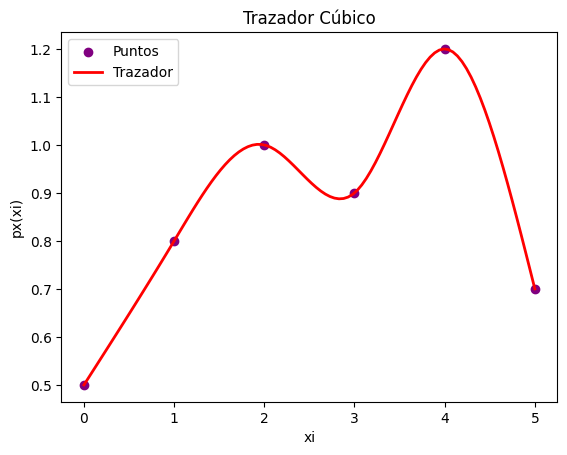

In [35]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

class TrazadorCubicoProcessor:
    def __init__(self, processor):
        self.processor = processor
        self.px_tabla = None

    def calcular_trazador_cubico(self):
        xi = self.processor.xi_1
        yi = self.processor.yi_1
        n = len(xi)

        # Creando el valor h
        h = np.zeros(n-1)
        for j in range(n-1):
            h[j] = xi[j+1] - xi[j]

        # Sistema de ecuaciones
        A = np.zeros((n-2, n-2))
        B = np.zeros(n-2)
        S = np.zeros(n)

        A[0, 0] = 2 * (h[0] + h[1])
        A[0, 1] = h[1]
        B[0] = 6 * ((yi[2] - yi[1]) / h[1] - (yi[1] - yi[0]) / h[0])

        for i in range(1, n-3):
            A[i, i-1] = h[i]
            A[i, i] = 2 * (h[i] + h[i+1])
            A[i, i+1] = h[i+1]
            factor21 = (yi[i+2] - yi[i+1]) / h[i+1]
            factor10 = (yi[i+1] - yi[i]) / h[i]
            B[i] = 6 * (factor21 - factor10)

        A[n-3, n-3] = 2 * (h[n-3] + h[n-2])
        A[n-3, n-4] = h[n-3]
        factor12 = (yi[n-1] - yi[n-2]) / h[n-2]
        factor23 = (yi[n-2] - yi[n-3]) / h[n-3]
        B[n-3] = 6 * (factor12 - factor23)

        # Resolver el sistema de ecuaciones
        r = np.linalg.solve(A, B)

        for j in range(1, n-1):
            S[j] = r[j-1]

        S[0] = 0
        S[n-1] = 0

        # Coeficientes
        a = np.zeros(n-1)
        b = np.zeros(n-1)
        c = np.zeros(n-1)
        d = np.zeros(n-1)

        for j in range(n-1):
            a[j] = (S[j+1] - S[j]) / (6 * h[j])
            b[j] = S[j] / 2
            factor10 = (yi[j+1] - yi[j]) / h[j]
            c[j] = factor10 - (2 * h[j] * S[j] + h[j] * S[j+1]) / 6
            d[j] = yi[j]

        # Construcción del polinomio
        x = sp.symbols("x")
        self.px_tabla = []

        for j in range(n-1):
            pxtramo = a[j] * (x - xi[j])**3 + b[j] * (x - xi[j])**2
            pxtramo += c[j] * (x - xi[j]) + d[j]
            pxtramo = sp.expand(pxtramo)
            self.px_tabla.append(pxtramo)

    def graficar(self):
        xi = self.processor.xi_1
        x_vals = np.linspace(xi[0], xi[-1], 100)

        # Evaluación
        x = sp.symbols("x")
        y_vals = np.zeros_like(x_vals)

        for tramo in range(len(self.px_tabla)):
            a, b = xi[tramo], xi[tramo+1]
            mask = (x_vals >= a) & (x_vals <= b)

            pxtramo = self.px_tabla[tramo]
            pxt = sp.lambdify(x, pxtramo, "numpy")
            y_vals[mask] = pxt(x_vals[mask])

        # Gráfica
        plt.scatter(xi, self.processor.yi_1, label="Puntos", color="purple")
        plt.plot(x_vals, y_vals, label="Trazador", color="red", linewidth=2)
        plt.title("Trazador Cúbico")
        plt.xlabel("xi")
        plt.ylabel("px(xi)")
        plt.legend()
        plt.show()

# Uso de las clases
if __name__ == "__main__":
    trazador = TrazadorCubicoProcessor(processor)
    trazador.calcular_trazador_cubico()
    trazador.graficar()


<hr>

## Paso 2: Polinomio de Mínimos Cuadrados

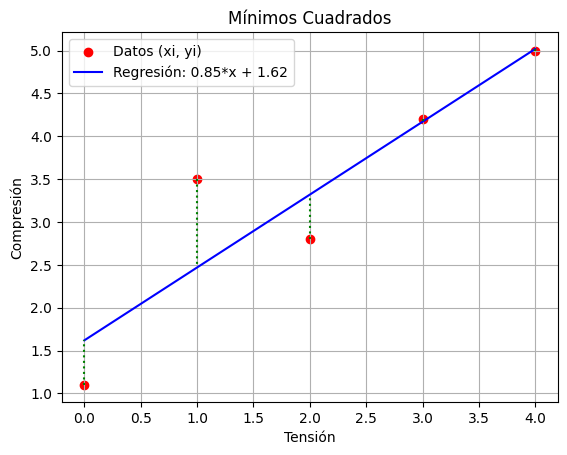

f(x) = 0.85*x + 1.62
Coeficiente de correlación r  = 0.9047
Coeficiente de determinación r² = 0.8184
81.84% de los datos está descrito en el modelo lineal


In [36]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

class RegresionLinealProcessor:
    def __init__(self, processor):
        self.processor = processor
        self.xi = processor.xi_2
        self.yi = processor.yi_2
        self.n = len(self.xi)
        self.coeficientes = self._calcular_coeficientes()
        self.pol_regresion = self._crear_polinomio()
        self.correlacion = self._calcular_correlacion()

    def _calcular_coeficientes(self):
        xm = np.mean(self.xi)
        ym = np.mean(self.yi)
        sx = np.sum(self.xi)
        sy = np.sum(self.yi)
        sxy = np.sum(self.xi * self.yi)
        sx2 = np.sum(self.xi**2)
        
        a1 = (self.n * sxy - sx * sy) / (self.n * sx2 - sx**2)
        a0 = ym - a1 * xm
        
        return a0, a1

    def _crear_polinomio(self):
        x = sp.Symbol("x")
        a0, a1 = self.coeficientes
        return a0 + a1 * x

    def _calcular_correlacion(self):
        sx = np.sum(self.xi)
        sy = np.sum(self.yi)
        sxy = np.sum(self.xi * self.yi)
        sx2 = np.sum(self.xi**2)
        sy2 = np.sum(self.yi**2)
        
        numerador = self.n * sxy - sx * sy
        raiz1 = np.sqrt(self.n * sx2 - sx**2)
        raiz2 = np.sqrt(self.n * sy2 - sy**2)
        
        r = numerador / (raiz1 * raiz2)
        r2 = r**2
        r2_porcentaje = round(r2 * 100, 2)
        
        return r, r2, r2_porcentaje

    def obtener_funcion_numpy(self):
        x = sp.Symbol("x")
        return sp.lambdify(x, self.pol_regresion, "numpy")

    def obtener_resultados(self):
        a0, a1 = self.coeficientes
        r, r2, r2_porcentaje = self.correlacion
        return {
            "polinomio": sp.expand(self.pol_regresion),
            "a0": a0,
            "a1": a1,
            "r": r,
            "r2": r2,
            "r2_porcentaje": r2_porcentaje
        }


class GraficadorLinealProcessor:
    def __init__(self, regresion_processor):
        self.regresion = regresion_processor

    def graficar(self):
        resultados = self.regresion.obtener_resultados()
        xi = self.regresion.xi
        yi = self.regresion.yi
        fx = self.regresion.obtener_funcion_numpy()
        fi = fx(xi)
        
        x_vals = np.linspace(xi[0], xi[-1], 100)
        
        # Gráfica
        plt.scatter(xi, yi, color="red", label="Datos (xi, yi)")
        plt.plot(x_vals, fx(x_vals), color="blue", label=f"Regresión: {resultados['polinomio']}")
        
        # Líneas de error
        for i in range(len(xi)):
            plt.plot([xi[i], xi[i]], [yi[i], fi[i]], color="green", linestyle="dotted")
        
        plt.xlabel("Tensión")
        plt.ylabel("Compresión")
        plt.title("Mínimos Cuadrados")
        plt.legend()
        plt.grid()
        plt.show()

        print(f"f(x) = {resultados['polinomio']}")
        print(f"Coeficiente de correlación r  = {resultados['r']:.4f}")
        print(f"Coeficiente de determinación r² = {resultados['r2']:.4f}")
        print(f"{resultados['r2_porcentaje']}% de los datos está descrito en el modelo lineal")


# Uso de las clases
if __name__ == "__main__":
    regresion_processor = RegresionLinealProcessor(processor)
    graficador = GraficadorLinealProcessor(regresion_processor)
    graficador.graficar()



<hr>

## Paso 3: Polinomios Ortogonales

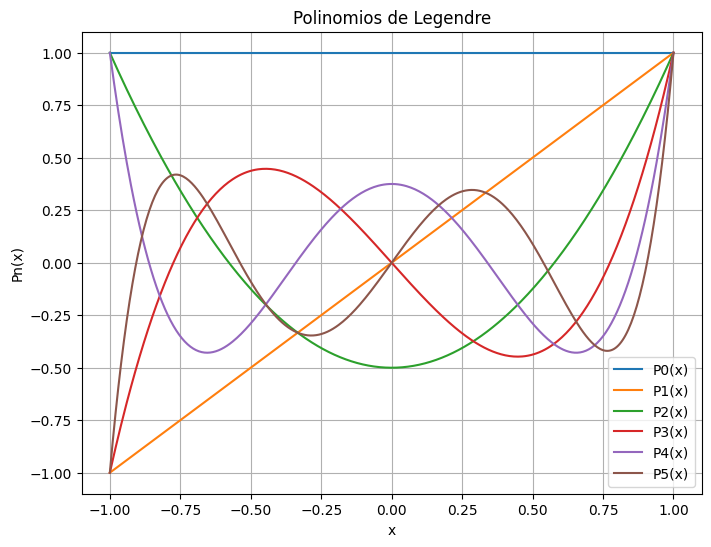

In [37]:
import numpy as np
import matplotlib.pyplot as plt

class PolinomiosLegendre:
    def __init__(self, n_max, x_values):
        """
        Inicializa la clase con el grado máximo y los valores de x.
        
        Parámetros:
        - n_max: grado máximo de los polinomios.
        - x_values: array de valores de x sobre los cuales se evaluarán los polinomios.
        """
        self.n_max = n_max
        self.x_values = x_values
        self.polinomios = self._generar_polinomios()

    def _polinomio_legendre(self, n, x):
        """
        Calcula recursivamente el polinomio de Legendre de grado n evaluado en x.
        """
        if n == 0:
            return np.ones(len(x))
        elif n == 1:
            return x
        else:
            p_n_1 = self._polinomio_legendre(n - 1, x)
            p_n_2 = self._polinomio_legendre(n - 2, x)
            return ((2 * n - 1) * x * p_n_1 - (n - 1) * p_n_2) / n

    def _generar_polinomios(self):
        """
        Genera los polinomios de Legendre desde P0 hasta Pₙ₍ₘₐₓ₎ evaluados en x_values.
        """
        return [self._polinomio_legendre(n, self.x_values) for n in range(self.n_max + 1)]

    def graficar(self):
        """
        Grafica todos los polinomios de Legendre generados.
        """
        plt.figure(figsize=(8, 6))
        for n, valores in enumerate(self.polinomios):
            plt.plot(self.x_values, valores, label=f"P{n}(x)")
        plt.xlabel("x")
        plt.ylabel("Pn(x)")
        plt.title("Polinomios de Legendre")
        plt.legend()
        plt.grid(True)
        plt.ylim(-1.1, 1.1)
        plt.show()

# Uso de la clase
if __name__ == "__main__":
    x = np.linspace(-1, 1, 400)
    n_max = 5
    legendre = PolinomiosLegendre(n_max, x)
    legendre.graficar()


<hr>

## Paso 4: Resolución de Ecuaciones

In [38]:
import numpy as np
import sympy as sp

class SistemaEcuacionesLineales:
    def __init__(self, processor):
        self.processor = processor
        self.A = sp.Matrix(processor.A.tolist())  # Convertir matriz a formato de sympy
        self.b = sp.Matrix(processor.b.tolist())  # Convertir vector columna a sympy
        self.variables = sp.symbols(f"x1:{self.A.shape[1] + 1}")
        self.solucion = None
        self.valores = None

    def resolver(self):
        # Resolver el sistema de ecuaciones Ax = b
        self.solucion = sp.linsolve((self.A, self.b), *self.variables)

        if self.solucion:
            # Extraer valores numéricos de la solución
            solucion_lista = list(self.solucion)[0]
            self.valores = [float(valor) for valor in solucion_lista]

    def mostrar_solucion(self):
        if self.solucion:
            print("Resolución de Ecuaciones Lineales:")
            sp.pprint(self.solucion)
            print("\nValores numéricos:")
            for i, valor in enumerate(self.valores, start=1):
                print(f"x{i} = {valor:.4f}")
        else:
            print("No hay solución al sistema de ecuaciones.")

# Uso de la clase
if __name__ == "__main__":
    sistema = SistemaEcuacionesLineales(processor)
    sistema.resolver()
    sistema.mostrar_solucion()


Resolución de Ecuaciones Lineales:
⎧⎛      14     ⎞⎫
⎨⎜-1/5, ──, 7/3⎟⎬
⎩⎝      15     ⎠⎭

Valores numéricos:
x1 = -0.2000
x2 = 0.9333
x3 = 2.3333
